[View in Colaboratory](https://colab.research.google.com/github/MariamMohamedFawzy/Deep-Learning-Notebooks/blob/master/Prepare_transformed_test_data_for_face_segmentation.ipynb)

In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import keras

# Download and reading the data

In [2]:
!git clone https://github.com/arahusky/Tensorflow-Segmentation.git

Cloning into 'Tensorflow-Segmentation'...
remote: Counting objects: 26322, done.
remote: Total 26322 (delta 0), reused 0 (delta 0), pack-reused 26322
Receiving objects: 100% (26322/26322), 122.86 MiB | 33.63 MiB/s, done.
Resolving deltas: 100% (454/454), done.
Checking out files: 100% (26383/26383), done.


In [3]:
!ls -l Tensorflow-Segmentation/data128_128/targets_face_only/ | wc -l

2928


In [4]:
!ls -l Tensorflow-Segmentation/data128_128/inputs/ | wc -l

2928


In [0]:
X_test = []
Y_test = []

In [0]:
for file_name in os.listdir('Tensorflow-Segmentation/data128_128/inputs/'):
  X_test.append(cv2.imread("Tensorflow-Segmentation/data128_128/inputs/" + file_name, 0))
  img_test = cv2.imread("Tensorflow-Segmentation/data128_128/targets_face_only/" + file_name, 0)
  Y_test.append(cv2.threshold(img_test,127,1,cv2.THRESH_BINARY)[1])

In [0]:
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [8]:
X_test.shape, Y_test.shape

((2927, 128, 128), (2927, 128, 128))

In [64]:
np.unique(X_test)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [65]:
np.unique(Y_test)

array([0, 1], dtype=uint8)

In [0]:
size_x, size_y = 128, 128

# Data Transformation

**Scaling**

In [0]:
def zoom_in(img, pix_x = 10, pix_y = 10):
  new_img = img[pix_x:size_x-pix_x, pix_y:size_y-pix_y]
  new_img = cv2.resize(new_img, (size_x, size_y))
  return new_img

In [0]:
def flip_lr(img):
  new_img = cv2.flip(img, 1)
  return new_img

In [0]:
def shear(img, shear_x=.1, shear_y=.1):
  pts1 = np.float32([[5,5],[20,5],[5,20]])

  pt1 = 5 + 5 * shear_x
  pt2 = 5 * shear_y + 5
  
  pt3 = 20 + 5 * shear_x
  pt4 = 20 * shear_y + 5
  
  pt5 = 5 + 20 * shear_x
  pt6 = 5 * shear_y + 20

  pts2 = np.float32([[pt1,pt2],[pt3,pt4],[pt5,pt6]])

  shear_M = cv2.getAffineTransform(pts1,pts2)
  
  new_img = cv2.warpAffine(img,shear_M,(size_x,size_y))
  
  return new_img

In [0]:
# https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
 
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

def change_contrast(img, gamma=0.5):
  new_img = adjust_gamma(img, gamma=gamma)
  return new_img

In [0]:
# https://stackoverflow.com/questions/31528800/how-to-implement-zca-whitening-python
def zca_whitening(img):
    new_img = np.reshape(img, (1,-1))
    sigma = np.dot(new_img, new_img.T)/new_img.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)        #ZCA Whitening matrix
    new_img =  np.dot(ZCAMatrix, new_img)   #Data whitening
    new_img = new_img.reshape(size_x, size_y)
    return new_img

In [0]:
def salt_pep_noise(img, prop = 0.98):
  mask = np.random.randint(0, 256, (img.shape[0], img.shape[1])).reshape((size_x*size_y))
  ones_mask = np.array(list(map(lambda x: 255 if x > prop * 255 else 0, mask))).reshape((size_x, size_y))
  zeros_mask = np.array(list(map(lambda x: 0 if x < (1-prop)*255 else 1, mask))).reshape((size_x, size_y))
  new_img = np.clip(img + ones_mask, 0, 255) * zeros_mask
  return new_img

In [0]:
def gaus_blur(img):
  kernel = np.ones((5,5),np.float32)/25
  return cv2.filter2D(img,-1,kernel)

In [0]:
def shift_down(img, pix=20):
  new_img = img.copy()
  new_img[pix:size_x, :] = new_img[:size_x-pix, :]
  new_img[:pix, :] = 0
  return new_img

In [0]:
def shift_up(img, pix=20):
  new_img = img.copy()
  new_img[:size_x-pix, :] = new_img[pix:size_x, :]
  new_img[size_x-pix:, :] = 0
  return new_img

In [0]:
def shift_right(img, pix=20):
  new_img = img.copy()
  new_img[:, pix:size_y] = new_img[:, :size_y-pix]
  new_img[:, :pix] = 0
  return new_img

In [0]:
def shift_left(img, pix=20):
  new_img = img.copy()
  new_img[:, :size_y-pix] = new_img[:, pix:size_y]
  new_img[:, size_y-pix:] = 0
  return new_img

In [0]:
def rotate(img, angle=20):
  M = cv2.getRotationMatrix2D((size_x/2,size_y/2),angle,1)
  return cv2.warpAffine(img,M,(size_x,size_y))

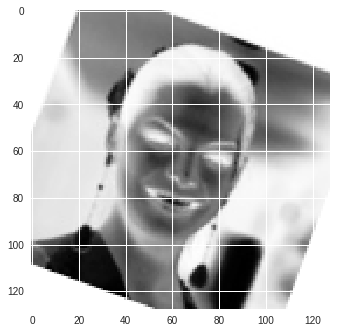

In [243]:
plt.imshow(rotate(X_test[1], angle=-20))

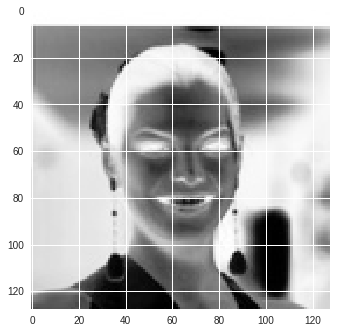

In [217]:
plt.imshow(X_test[1])

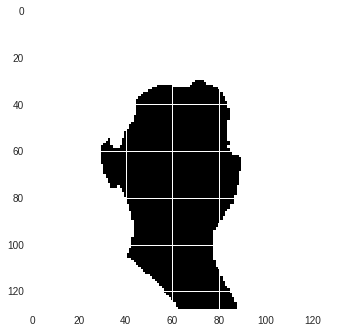

In [230]:
plt.imshow(Y_test[1])

# Apply on data

In [0]:
def get_sample(all_count=2927, num=50):
  ind = np.random.choice(all_count, num)
  return ind

In [0]:
X = []
Y = []

In [0]:
sample = get_sample()

X_temp = X_test[sample]
Y_temp = Y_test[sample]

X_temp = list(map(zoom_in, X_temp))
Y_temp = list(map(zoom_in, Y_temp))

X_temp = list(map(flip_lr, X_temp))
Y_temp = list(map(flip_lr, Y_temp))

X_temp = list(map(change_contrast, X_temp))

X.extend(X_temp)
Y.extend(Y_temp)

In [0]:
sample = get_sample()

X_temp = X_test[sample]
Y_temp = Y_test[sample]

X_temp = list(map(gaus_blur, X_temp))

X_temp = list(map(rotate, X_temp))
Y_temp = list(map(rotate, Y_temp))

X.extend(X_temp)
Y.extend(Y_temp)

In [0]:
sample = get_sample()

X_temp = X_test[sample]
Y_temp = Y_test[sample]

X_temp = list(map(change_contrast, X_temp))

X_temp = list(map(shift_right, X_temp))
Y_temp = list(map(shift_right, Y_temp))

X_temp = list(map(flip_lr, X_temp))
Y_temp = list(map(flip_lr, Y_temp))

X.extend(X_temp)
Y.extend(Y_temp)

In [0]:
sample = get_sample()

X_temp = X_test[sample]
Y_temp = Y_test[sample]

X_temp = list(map(shear, X_temp))
Y_temp = list(map(shear, Y_temp))

X_temp = list(map(shift_up, X_temp))
Y_temp = list(map(shift_up, Y_temp))

X_temp = list(map(salt_pep_noise, X_temp))

X.extend(X_temp)
Y.extend(Y_temp)

In [0]:
X = np.array(X)
Y = np.array(Y)

In [256]:
X.shape, Y.shape

((200, 128, 128), (200, 128, 128))